In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import bambi as bmb
import theano
import arviz as az
import os
cwd = os.getcwd() # Get direction
import warnings
warnings.filterwarnings('ignore')
import R2_Bayes as r2

In [19]:
DF= pd.read_csv(cwd[:-4]+'/Data/data_farmclass_state.csv')

In [20]:
DF.columns

Index(['year', 'state_name', 'state_fips_code', 'domaincat_desc',
       'ACRES OPERATED', 'NUMBER OF OPERATIONS', 'farmcat', 'lower_bound',
       'upper_bound', '(EXCL CRP) - ACRES', 'DRAINED BY TILE - ACRES',
       '(EXCL CRP) - NUMBER OF OPERATIONS',
       'DRAINED BY TILE - NUMBER OF OPERATIONS', 'CROP INSURANCE - ACRES',
       'CROP INSURANCE - NUMBER OF OPERATIONS',
       'IRRIGATED - NUMBER OF OPERATIONS_x', 'RENTED FROM OTHERS_x',
       'RENTED FROM OTHERS_y', 'OWNED_x', 'OWNED_y', 'IRRIGATED - ACRES',
       'IRRIGATED - NUMBER OF OPERATIONS_y',
       'NET INCOME, MEASURED IN $ / OPERATION', 'FEDERAL - RECEIPTS',
       'FEDERAL - OPERATIONS WITH RECEIPTS', 'tot_income', 'income_ope',
       'STATE & LOCAL - RECEIPTS', 'STATE & LOCAL - OPERATIONS WITH RECEIPTS',
       'HIRED - EXPENSE', 'HIRED - OPERATIONS WITH EXPENSE',
       'CONTRACT - EXPENSE', 'CONTRACT - OPERATIONS WITH EXPENSE',
       'EXPENSE, MEASURED IN $', 'OPERATIONS WITH EXPENSE',
       'MACHINERY TOTAL

In [21]:
#DF.loc[DF.insured_farms > 1, 'insured_farms'] = 1
DF['mean_farmsize']= DF['ACRES OPERATED']/DF['NUMBER OF OPERATIONS']
DF['tavg_sd']= DF['tavg_coeff']* DF['tavg_mean']
DF['pcp_sd']= DF['pcp_mm_coeff']* DF['pcp_mm_mean']
DF['edd_sd']= DF['edd_coeff']* DF['edd_mean']
DF['pcpdays_sd']= DF['pcpdays_coeff']* DF['pcpdays_mean']

In [22]:
DF= DF[DF['state_name']!= 'ALASKA']
DF= DF[DF['state_name']!= 'HAWAII']

In [23]:
print((DF['mean_farmincome'][(DF['farm_class']=='Small') & (DF['year']==2022)]).mean())
print((DF['mean_farmincome'][(DF['farm_class']=='Medium') & (DF['year']==2022)]).mean())

20857.928009864565
29318.19492352866


In [24]:
def dfsummary(trace):
    dfy= az.summary(trace)
    dfy['variables'] =dfy.index
    dfy['farm_class']= dfy.variables.str[-2:-1]
    
    return dfy

### Prepare data for Bayesian Models

In [25]:
DF.dropna(axis=0, how='any',subset=['tile_ope','mean_farmsize',
          'insured_farms','fed_income', 'statepay_ope', 
          'labor_expense','machinery_asset', 'rented_land',
          'grains_shareope', 'veggies_shareope','cattle_shareope',
           'edd_mean','pcpdays_mean',
          'tavg_sd', 'pcp_sd'], inplace=True)

In [8]:
DF

,year,state_name,state_fips_code,domaincat_desc,ACRES OPERATED,NUMBER OF OPERATIONS,farmcat,lower_bound,upper_bound,(EXCL CRP) - ACRES,...,labor_expense,labor_share,machinery_asset,grains_shareope,veggies_shareope,fruit_shareope,cattle_shareope,year_2017,year_2022,mean_farmsize
0,2012,ALABAMA,1,AREA OPERATED: (1.0 TO 9.9 ACRES),14379.0,2919,1-10,1,9.0,139.0,...,0.077132,5.259637,36.973545,0.013703,0.079822,0.073998,0.220281,0,0,4.926002
1,2012,ALABAMA,1,AREA OPERATED: (10.0 TO 49.9 ACRES),362197.0,13267,10-50,10,49.0,2651.0,...,0.047568,3.586960,37.800758,0.024648,0.035803,0.036858,0.373785,0,0,27.300595
2,2012,ALABAMA,1,AREA OPERATED: (50.0 TO 69.9 ACRES),246346.0,4235,50-70,50,69.0,1984.0,...,0.040040,2.121030,34.715225,0.037308,0.016765,0.023849,0.452893,0,0,58.169067
3,2012,ALABAMA,1,AREA OPERATED: (70.0 TO 99.9 ACRES),377435.0,4605,70-100,70,99.0,2921.0,...,0.031832,1.831556,39.152023,0.029967,0.018458,0.022150,0.488599,0,0,81.961998
4,2012,ALABAMA,1,AREA OPERATED: (100 TO 139 ACRES),500043.0,4342,100-140,100,139.0,3569.0,...,0.036771,1.839224,30.717884,0.034086,0.019116,0.024413,0.463611,0,0,115.164210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,2022,WYOMING,56,AREA OPERATED: (220 TO 259 ACRES),55708.0,234,220-260,220,259.0,641.0,...,0.076909,0.328539,7.886828,0.038462,0.000000,0.000000,0.363248,0,1,238.068376
1724,2022,WYOMING,56,AREA OPERATED: (260 TO 499 ACRES),320538.0,887,260-500,260,499.0,2525.0,...,0.105112,0.487556,8.916783,0.084555,0.001127,0.000000,0.394589,0,1,361.373168
1725,2022,WYOMING,56,AREA OPERATED: (500 TO 999 ACRES),619090.0,882,500-1K,500,999.0,5269.0,...,0.110806,1.464455,17.723672,0.071429,0.000000,0.001134,0.460317,0,1,701.916100
1726,2022,WYOMING,56,"AREA OPERATED: (1,000 TO 1,999 ACRES)",1102112.0,798,1K-2K,1000,1999.0,6328.0,...,0.084350,1.982757,22.068111,0.077694,0.000000,0.000000,0.527569,0,1,1381.092732


In [26]:
# Keep counties with at least 2 observations
DF.sort_values(by= ['state_fips_code','farmcat','year'], inplace=True)
DF['cons']=1
DF['times']= DF.groupby(['state_fips_code','farmcat'])['cons'].transform(sum)

In [27]:
## Remove inf vals
DF.replace([np.inf, -np.inf], np.nan, inplace=True)
## Selected variables for inference
fe_vars= ['tile_ope','mean_farmsize',
          'insured_farms','fed_income', 'statepay_ope', 
          'labor_expense','machinery_asset', 'rented_land',
          'grains_shareope', 'veggies_shareope','cattle_shareope',
           'tavg_mean', 'pcp_mm_mean','edd_mean','pcpdays_mean',
          'tavg_sd', 'pcp_sd','edd_sd','pcpdays_sd',
        'tavg_z', 'pcp_mm_z', 'edd_z','pcpdays_z']
DF1= DF[['times','state_fips_code','year','farmcat','farm_class','class','year_2017', 'year_2022']+fe_vars]
DF1= DF1[DF1['times']>1] # select farm groups with more that 2 years of data

#Standardize variables within farm size and state groups
for x in fe_vars:    
    DF1[x+'_fe']= (DF1[x] - DF1.groupby(['state_fips_code','farmcat'])[x].transform('mean'))/(DF1.groupby(['state_fips_code','farmcat'])[x].transform('std'))
    


(array([ 99.,  36.,  36.,  24.,  39.,  22.,  51.,  34.,  12.,  62.,  54.,
          0., 154.,   0.,  24.,  54.,  12.,  22.,  12.,  27.,  36.,  10.,
         39.,   0.,  12.,  24.,  24.,   0.,  12.,  24.,   0.,  40.,  12.,
         23.,   0.,  12.,   0.,  24.,   0.,  12.,  46.,  15.,  52.,  24.,
         12.,  24.,  24.,  51.,  61., 213.]),
 array([-1.15468633e+00, -1.10849863e+00, -1.06231094e+00, -1.01612325e+00,
        -9.69935552e-01, -9.23747858e-01, -8.77560164e-01, -8.31372470e-01,
        -7.85184776e-01, -7.38997082e-01, -6.92809388e-01, -6.46621694e-01,
        -6.00434000e-01, -5.54246306e-01, -5.08058612e-01, -4.61870918e-01,
        -4.15683224e-01, -3.69495530e-01, -3.23307836e-01, -2.77120142e-01,
        -2.30932448e-01, -1.84744754e-01, -1.38557060e-01, -9.23693665e-02,
        -4.61816725e-02,  6.02150004e-06,  4.61937155e-02,  9.23814095e-02,
         1.38569103e-01,  1.84756797e-01,  2.30944491e-01,  2.77132185e-01,
         3.23319879e-01,  3.69507573e-01,  4.15695

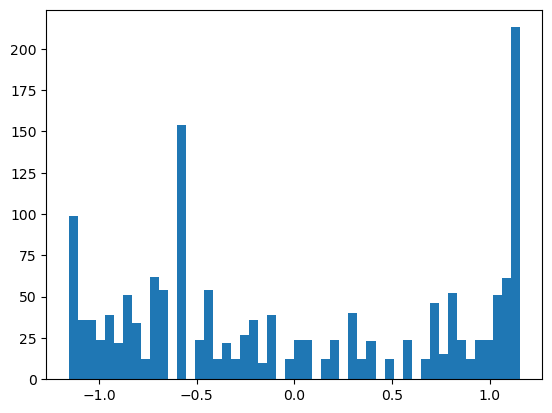

In [10]:
plt.hist(DF1['tavg_sd_fe'], bins=50)

In [11]:
DF1

,times,state_fips_code,year,farmcat,farm_class,class,year_2017,year_2022,tile_ope,mean_farmsize,...,edd_mean_fe,pcpdays_mean_fe,tavg_sd_fe,pcp_sd_fe,edd_sd_fe,pcpdays_sd_fe,tavg_z_fe,pcp_mm_z_fe,edd_z_fe,pcpdays_z_fe
0,3,1,2012,1-10,Small,0,0,0,0.013703,4.926002,...,-0.795682,-1.146333,1.154456,1.022485,-1.111816,0.947722,0.914449,-0.900068,-0.851839,-1.152642
576,3,1,2017,1-10,Small,0,1,0,0.012111,4.965318,...,-0.326843,0.452998,-0.556668,-0.046599,0.285909,0.097425,-1.067828,-0.176391,-0.249194,0.636008
1152,3,1,2022,1-10,Small,0,0,1,0.011650,4.857948,...,1.122525,0.693335,-0.597789,-0.975886,0.825907,-1.045147,0.153379,1.076459,1.101033,0.516634
1,3,1,2012,10-50,Small,0,0,0,0.015829,27.300595,...,-0.795682,-1.146333,1.154456,1.022485,-1.111816,0.947722,0.914449,-0.900068,-0.851839,-1.152642
577,3,1,2017,10-50,Small,0,1,0,0.020416,27.055630,...,-0.326843,0.452998,-0.556668,-0.046599,0.285909,0.097425,-1.067828,-0.176391,-0.249194,0.636008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1143,3,56,2017,70-100,Small,0,1,0,0.025825,81.278336,...,-0.285703,0.849228,-0.753974,-1.129887,-1.131138,0.783805,0.363035,1.059928,-0.297725,0.510567
1719,3,56,2022,70-100,Small,0,0,1,0.031097,81.194763,...,1.111758,-1.102190,-0.380405,0.358747,0.766554,-1.126230,0.767774,-0.926719,1.115051,-1.152218
575,3,56,2012,>2K,Large,2,0,0,0.020077,11786.334900,...,-0.826055,0.252962,1.134379,0.771140,0.364584,0.342425,-1.130809,-0.133209,-0.817326,0.641651
1151,3,56,2017,>2K,Large,2,1,0,0.020890,11978.582198,...,-0.285703,0.849228,-0.753974,-1.129887,-1.131138,0.783805,0.363035,1.059928,-0.297725,0.510567


# Pooled model

In [63]:
# Priors
st_sd=1
priorsp = {
    'Intercept': bmb.Prior("Normal", mu= 0, sigma= st_sd),
    'mean_farmsize_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'insured_farms_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'fed_income_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'statepay_ope_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'labor_expense_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'rented_land_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'machinery_asset_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'grains_shareope_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'veggies_shareope_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'cattle_shareope_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    #'tavg_mean_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    #'pcp_mm_mean_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'edd_mean_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'pcpdays_mean_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'tavg_sd_fe': bmb.Prior("Laplace", mu= 0, b= st_sd), 
    'pcp_sd_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    #'edd_sd_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    #'pcpdays_sd_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'tavg_z_fe': bmb.Prior("Laplace", mu= 0, b= st_sd), 
    'pcp_mm_z_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    #'edd_z_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    #'pcpdays_z_fe': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'year_2017': bmb.Prior('Laplace', mu= 0, b= st_sd),
    'year_2022': bmb.Prior('Laplace', mu= 0, b= st_sd),
    'sigma': bmb.Prior('HalfCauchy', beta= st_sd)
}
## Pooled model
modelp = bmb.Model("tile_ope_fe ~ 1+ (mean_farmsize_fe)\
                    +(insured_farms_fe)+\
       (fed_income_fe)+ (statepay_ope_fe)+(labor_expense_fe)+\
       (machinery_asset_fe)+ (rented_land_fe)+(grains_shareope_fe)+\
       (veggies_shareope_fe)+(cattle_shareope_fe)+\
       (edd_mean_fe)+(pcpdays_mean_fe)+\
       (tavg_sd_fe) + (pcp_sd_fe) +(tavg_z_fe)+ (pcp_mm_z_fe)+\
       (year_2017)+(year_2022)", 
                     DF1, priors= priorsp, dropna=True)
modelp

Formula: tile_ope_fe ~ 1+ (mean_farmsize_fe)                    +(insured_farms_fe)+       (fed_income_fe)+ (statepay_ope_fe)+(labor_expense_fe)+       (machinery_asset_fe)+ (rented_land_fe)+(grains_shareope_fe)+       (veggies_shareope_fe)+(cattle_shareope_fe)+       (edd_mean_fe)+(pcpdays_mean_fe)+       (tavg_sd_fe) + (pcp_sd_fe) +(tavg_z_fe)+ (pcp_mm_z_fe)+       (year_2017)+(year_2022)
Family name: Gaussian
Link: identity
Observations: 1547
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 1)
    mean_farmsize_fe ~ Laplace(mu: 0, b: 1)
    insured_farms_fe ~ Laplace(mu: 0, b: 1)
    fed_income_fe ~ Laplace(mu: 0, b: 1)
    statepay_ope_fe ~ Laplace(mu: 0, b: 1)
    labor_expense_fe ~ Laplace(mu: 0, b: 1)
    machinery_asset_fe ~ Laplace(mu: 0, b: 1)
    rented_land_fe ~ Laplace(mu: 0, b: 1)
    grains_shareope_fe ~ Laplace(mu: 0, b: 1)
    veggies_shareope_fe ~ Laplace(mu: 0, b: 1)
    cattle_shareope_fe ~ Laplace(mu: 0, b: 1)
    edd_mean_fe ~ Laplace(mu: 0, b: 

In [64]:
tracep = modelp.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.99,random_seed=21)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tile_ope_fe_sigma, Intercept, year_2022, year_2017, pcp_mm_z_fe, tavg_z_fe, pcp_sd_fe, tavg_sd_fe, pcpdays_mean_fe, edd_mean_fe, cattle_shareope_fe, veggies_shareope_fe, grains_shareope_fe, rented_land_fe, machinery_asset_fe, labor_expense_fe, statepay_ope_fe, fed_income_fe, insured_farms_fe, mean_farmsize_fe]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 116 seconds.


In [14]:
az.loo(tracep)

Computed from 4000 posterior samples and 1547 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1802.79    17.65
p_loo       23.25        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1547  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [65]:
az.summary(tracep)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.022,0.072,-0.156,0.114,0.002,0.001,1980.0,2415.0,1.0
mean_farmsize_fe,0.070,0.025,0.019,0.113,0.000,0.000,4469.0,2930.0,1.0
insured_farms_fe,0.110,0.031,0.050,0.166,0.001,0.000,3745.0,3267.0,1.0
fed_income_fe,-0.007,0.029,-0.059,0.048,0.000,0.000,3413.0,3067.0,1.0
statepay_ope_fe,-0.031,0.025,-0.077,0.016,0.000,0.000,3918.0,2854.0,1.0
labor_expense_fe,-0.009,0.028,-0.062,0.043,0.000,0.000,3643.0,2871.0,1.0
machinery_asset_fe,0.045,0.027,-0.005,0.097,0.000,0.000,3293.0,2835.0,1.0
rented_land_fe,0.066,0.032,0.005,0.126,0.000,0.000,4188.0,2992.0,1.0
grains_shareope_fe,0.043,0.027,-0.006,0.095,0.000,0.000,4662.0,3320.0,1.0
veggies_shareope_fe,-0.005,0.025,-0.053,0.042,0.000,0.000,4513.0,3163.0,1.0


In [92]:

DF1['cons']=1

selvars=['cons', 'mean_farmsize_fe',
        'insured_farms_fe','fed_income_fe', 'statepay_ope_fe', 
        'labor_expense_fe','machinery_asset_fe', 'rented_land_fe',
        'grains_shareope_fe', 'veggies_shareope_fe','cattle_shareope_fe',
        'edd_mean_fe','pcpdays_mean_fe',
        'tavg_sd_fe', 'pcp_sd_fe','tavg_z_fe', 'pcp_mm_z_fe','year_2017','year_2022']


varspost= ['Intercept','mean_farmsize_fe',
        'insured_farms_fe','fed_income_fe', 'statepay_ope_fe', 
        'labor_expense_fe','machinery_asset_fe', 'rented_land_fe',
        'grains_shareope_fe', 'veggies_shareope_fe','cattle_shareope_fe',
        'edd_mean_fe','pcpdays_mean_fe',
        'tavg_sd_fe', 'pcp_sd_fe','tavg_z_fe', 'pcp_mm_z_fe','year_2017','year_2022']

DF1_clean= DF1
DF1_clean.dropna(axis=0, how='any',subset=['tile_ope_fe','mean_farmsize_fe',
        'insured_farms_fe','fed_income_fe', 'statepay_ope_fe', 
        'labor_expense_fe','machinery_asset_fe', 'rented_land_fe',
        'grains_shareope_fe', 'veggies_shareope_fe','cattle_shareope_fe',
        'edd_mean_fe','pcpdays_mean_fe',
        'tavg_sd_fe', 'pcp_sd_fe','tavg_z_fe', 'pcp_mm_z_fe','year_2017','year_2022'], inplace=True)


In [93]:
meanp, lcip, ucip= r2.Bayesian_Rsquared(DF1_clean, 'identity',tracep, 'tile_ope_fe',selvars,varspost, False, x,4,1000,x)

In [94]:
print('Mean CI:', meanp)
print('Lower CI:', lcip)
print('Upper CI:', ucip)

Mean CI: 0.10848032786369546
Lower CI: 0.08180923033637619
Upper CI: 0.13600000242216453


In [67]:
print(az.hdi(tracep,var_names=varspost[:12], hdi_prob = 0.90).values())
print(az.hdi(tracep,var_names=varspost[12:25], hdi_prob = 0.90).values())

ValuesView(<xarray.Dataset>
Dimensions:              (hdi: 2)
Coordinates:
  * hdi                  (hdi) <U6 'lower' 'higher'
Data variables:
    Intercept            (hdi) float64 -0.1315 0.1031
    mean_farmsize_fe     (hdi) float64 0.02806 0.1086
    insured_farms_fe     (hdi) float64 0.06019 0.1625
    fed_income_fe        (hdi) float64 -0.05783 0.03677
    statepay_ope_fe      (hdi) float64 -0.07042 0.0106
    labor_expense_fe     (hdi) float64 -0.05487 0.03863
    machinery_asset_fe   (hdi) float64 0.002172 0.09179
    rented_land_fe       (hdi) float64 0.01299 0.1179
    grains_shareope_fe   (hdi) float64 -0.005053 0.08401
    veggies_shareope_fe  (hdi) float64 -0.04282 0.04015
    cattle_shareope_fe   (hdi) float64 -0.1418 -0.04495
    edd_mean_fe          (hdi) float64 -0.03616 0.1592)
ValuesView(<xarray.Dataset>
Dimensions:          (hdi: 2)
Coordinates:
  * hdi              (hdi) <U6 'lower' 'higher'
Data variables:
    pcpdays_mean_fe  (hdi) float64 -0.02202 0.1158
    tav

In [68]:
print(az.hdi(tracep,var_names=varspost[:12], hdi_prob = 0.99).values())
print(az.hdi(tracep,var_names=varspost[12:25], hdi_prob = 0.99).values())

ValuesView(<xarray.Dataset>
Dimensions:              (hdi: 2)
Coordinates:
  * hdi                  (hdi) <U6 'lower' 'higher'
Data variables:
    Intercept            (hdi) float64 -0.1976 0.1775
    mean_farmsize_fe     (hdi) float64 0.004942 0.1345
    insured_farms_fe     (hdi) float64 0.025 0.1861
    fed_income_fe        (hdi) float64 -0.07871 0.06844
    statepay_ope_fe      (hdi) float64 -0.09312 0.03364
    labor_expense_fe     (hdi) float64 -0.0768 0.06676
    machinery_asset_fe   (hdi) float64 -0.0242 0.1157
    rented_land_fe       (hdi) float64 -0.01553 0.1485
    grains_shareope_fe   (hdi) float64 -0.02745 0.1094
    veggies_shareope_fe  (hdi) float64 -0.07053 0.06048
    cattle_shareope_fe   (hdi) float64 -0.1705 -0.0204
    edd_mean_fe          (hdi) float64 -0.09677 0.2005)
ValuesView(<xarray.Dataset>
Dimensions:          (hdi: 2)
Coordinates:
  * hdi              (hdi) <U6 'lower' 'higher'
Data variables:
    pcpdays_mean_fe  (hdi) float64 -0.06668 0.1505
    tavg_sd_

# Hierarchical model 

In [69]:
#st_sd= bmb.Prior("HalfCauchy", beta= 1)
st_sd = 1

priorsc = {
    '1|class': bmb.Prior("Normal", mu= 0, sigma= st_sd),
    'mean_farmsize_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'insured_farms_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'fed_income_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'statepay_ope_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'labor_expense_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'rented_land_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'machinery_asset_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'grains_shareope_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'veggies_shareope_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'cattle_shareope_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'edd_mean_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'pcpdays_mean_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'tavg_sd_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd), 
    'pcp_sd_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'tavg_z_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd), 
    'pcp_mm_z_fe|class': bmb.Prior("Laplace", mu= 0, b= st_sd),
    'year_2017|class': bmb.Prior('Laplace', mu= 0, b= st_sd),
    'year_2022|class': bmb.Prior('Laplace', mu= 0, b= st_sd),
    'sigma': bmb.Prior('HalfCauchy', beta= 1)
}


In [70]:
model = bmb.Model("tile_ope_fe ~ 0+(1|class)+(mean_farmsize_fe|class)+ (insured_farms_fe|class)+\
       (fed_income_fe|class)+ (statepay_ope_fe|class)+(labor_expense_fe|class)+\
       (machinery_asset_fe|class)+ (rented_land_fe|class)+(grains_shareope_fe|class)+\
       (veggies_shareope_fe|class)+(cattle_shareope_fe|class)+\
       (edd_mean_fe|class)+(pcpdays_mean_fe|class)+\
       (tavg_sd_fe|class) + (pcp_sd_fe|class)+(tavg_z_fe|class)+ (pcp_mm_z_fe|class) +\
       (year_2017|class)+ (year_2022|class)", 
        DF1, priors= priorsc, dropna=True)
#
model

Formula: tile_ope_fe ~ 0+(1|class)+(mean_farmsize_fe|class)+ (insured_farms_fe|class)+       (fed_income_fe|class)+ (statepay_ope_fe|class)+(labor_expense_fe|class)+       (machinery_asset_fe|class)+ (rented_land_fe|class)+(grains_shareope_fe|class)+       (veggies_shareope_fe|class)+(cattle_shareope_fe|class)+       (edd_mean_fe|class)+(pcpdays_mean_fe|class)+       (tavg_sd_fe|class) + (pcp_sd_fe|class)+(tavg_z_fe|class)+ (pcp_mm_z_fe|class) +       (year_2017|class)+ (year_2022|class)
Family name: Gaussian
Link: identity
Observations: 1547
Priors:
  Group-level effects
    1|class ~ Normal(mu: 0, sigma: 1)
    mean_farmsize_fe|class ~ Laplace(mu: 0, b: 1)
    insured_farms_fe|class ~ Laplace(mu: 0, b: 1)
    fed_income_fe|class ~ Laplace(mu: 0, b: 1)
    statepay_ope_fe|class ~ Laplace(mu: 0, b: 1)
    labor_expense_fe|class ~ Laplace(mu: 0, b: 1)
    machinery_asset_fe|class ~ Laplace(mu: 0, b: 1)
    rented_land_fe|class ~ Laplace(mu: 0, b: 1)
    grains_shareope_fe|class ~ Laplac

In [71]:
trace = model.fit(tune=1000, draws=1000, init="adapt_diag",target_accept=.99,random_seed=21)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tile_ope_fe_sigma, year_2022|class, year_2017|class, pcp_mm_z_fe|class, tavg_z_fe|class, pcp_sd_fe|class, tavg_sd_fe|class, pcpdays_mean_fe|class, edd_mean_fe|class, cattle_shareope_fe|class, veggies_shareope_fe|class, grains_shareope_fe|class, rented_land_fe|class, machinery_asset_fe|class, labor_expense_fe|class, statepay_ope_fe|class, fed_income_fe|class, insured_farms_fe|class, mean_farmsize_fe|class, 1|class]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 334 seconds.


In [72]:
df= dfsummary(trace)
df[df['farm_class']== '0']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm_class
1|class[0],-0.077,0.120,-0.298,0.151,0.003,0.002,1370.0,2204.0,1.0,1|class[0],0
mean_farmsize_fe|class[0],0.057,0.043,-0.021,0.137,0.001,0.001,4740.0,3276.0,1.0,mean_farmsize_fe|class[0],0
insured_farms_fe|class[0],0.126,0.060,0.018,0.241,0.001,0.001,3758.0,2959.0,1.0,insured_farms_fe|class[0],0
fed_income_fe|class[0],0.009,0.049,-0.080,0.100,0.001,0.001,3657.0,2768.0,1.0,fed_income_fe|class[0],0
statepay_ope_fe|class[0],-0.186,0.045,-0.274,-0.107,0.001,0.000,6120.0,3108.0,1.0,statepay_ope_fe|class[0],0
labor_expense_fe|class[0],-0.036,0.045,-0.124,0.047,0.001,0.001,5071.0,3177.0,1.0,labor_expense_fe|class[0],0
machinery_asset_fe|class[0],-0.004,0.045,-0.089,0.077,0.001,0.001,4141.0,3301.0,1.0,machinery_asset_fe|class[0],0
rented_land_fe|class[0],0.050,0.059,-0.055,0.164,0.001,0.001,3217.0,3065.0,1.0,rented_land_fe|class[0],0
grains_shareope_fe|class[0],0.025,0.043,-0.055,0.107,0.001,0.001,4397.0,3091.0,1.0,grains_shareope_fe|class[0],0
veggies_shareope_fe|class[0],0.050,0.043,-0.026,0.138,0.001,0.001,4728.0,3261.0,1.0,veggies_shareope_fe|class[0],0


In [73]:
df[df['farm_class']== '1']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm_class
1|class[1],0.023,0.123,-0.209,0.248,0.003,0.002,1583.0,2125.0,1.0,1|class[1],1
mean_farmsize_fe|class[1],0.063,0.040,-0.007,0.142,0.001,0.000,5398.0,2926.0,1.0,mean_farmsize_fe|class[1],1
insured_farms_fe|class[1],0.040,0.054,-0.057,0.148,0.001,0.001,3085.0,3109.0,1.0,insured_farms_fe|class[1],1
fed_income_fe|class[1],-0.064,0.052,-0.160,0.031,0.001,0.001,4334.0,3140.0,1.0,fed_income_fe|class[1],1
statepay_ope_fe|class[1],0.024,0.043,-0.056,0.104,0.001,0.001,4887.0,2901.0,1.0,statepay_ope_fe|class[1],1
labor_expense_fe|class[1],0.057,0.050,-0.031,0.157,0.001,0.001,4362.0,3003.0,1.0,labor_expense_fe|class[1],1
machinery_asset_fe|class[1],-0.023,0.048,-0.114,0.065,0.001,0.001,4396.0,2528.0,1.0,machinery_asset_fe|class[1],1
rented_land_fe|class[1],0.060,0.059,-0.045,0.173,0.001,0.001,4107.0,3267.0,1.0,rented_land_fe|class[1],1
grains_shareope_fe|class[1],0.166,0.048,0.078,0.255,0.001,0.001,3505.0,3162.0,1.0,grains_shareope_fe|class[1],1
veggies_shareope_fe|class[1],0.029,0.043,-0.052,0.110,0.001,0.001,5948.0,2517.0,1.0,veggies_shareope_fe|class[1],1


In [74]:
df[df['farm_class']== '2']

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,variables,farm_class
1|class[2],-0.003,0.113,-0.221,0.211,0.003,0.002,1580.0,1805.0,1.0,1|class[2],2
mean_farmsize_fe|class[2],0.101,0.045,0.022,0.190,0.001,0.001,4221.0,2890.0,1.0,mean_farmsize_fe|class[2],2
insured_farms_fe|class[2],0.073,0.053,-0.030,0.170,0.001,0.001,4191.0,2977.0,1.0,insured_farms_fe|class[2],2
fed_income_fe|class[2],-0.008,0.053,-0.111,0.087,0.001,0.001,3877.0,3162.0,1.0,fed_income_fe|class[2],2
statepay_ope_fe|class[2],0.041,0.046,-0.046,0.129,0.001,0.001,4538.0,3190.0,1.0,statepay_ope_fe|class[2],2
labor_expense_fe|class[2],-0.051,0.061,-0.167,0.060,0.001,0.001,3424.0,3016.0,1.0,labor_expense_fe|class[2],2
machinery_asset_fe|class[2],0.165,0.056,0.060,0.266,0.001,0.001,3620.0,2712.0,1.0,machinery_asset_fe|class[2],2
rented_land_fe|class[2],0.126,0.049,0.029,0.211,0.001,0.001,3774.0,3125.0,1.0,rented_land_fe|class[2],2
grains_shareope_fe|class[2],-0.042,0.048,-0.133,0.046,0.001,0.001,3795.0,3149.0,1.0,grains_shareope_fe|class[2],2
veggies_shareope_fe|class[2],-0.079,0.044,-0.160,0.004,0.001,0.001,4004.0,3057.0,1.0,veggies_shareope_fe|class[2],2


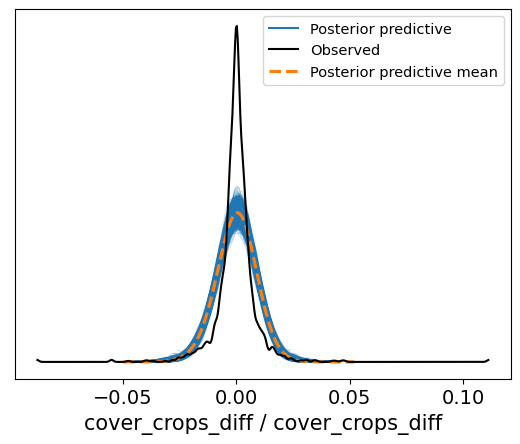

In [110]:
model.predict(trace, kind="pps")
az.plot_ppc(trace);

In [29]:
az.loo(trace)

Computed from 4000 posterior samples and 1547 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1799.18    19.14
p_loo       68.02        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1547  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

## R2 

In [84]:

DF1['cons']=1
selvars=['cons','mean_farmsize_fe',
        'insured_farms_fe','fed_income_fe', 'statepay_ope_fe', 
        'labor_expense_fe','machinery_asset_fe', 'rented_land_fe',
        'grains_shareope_fe', 'veggies_shareope_fe','cattle_shareope_fe',
        'edd_mean_fe','pcpdays_mean_fe',
        'tavg_sd_fe', 'pcp_sd_fe','tavg_z_fe','pcp_mm_z_fe', 'year_2017','year_2022']


varspost= ['1|class','mean_farmsize_fe|class',
        'insured_farms_fe|class','fed_income_fe|class', 'statepay_ope_fe|class', 
        'labor_expense_fe|class','machinery_asset_fe|class', 'rented_land_fe|class',
        'grains_shareope_fe|class', 'veggies_shareope_fe|class','cattle_shareope_fe|class',
        'edd_mean_fe|class','pcpdays_mean_fe|class',
        'tavg_sd_fe|class', 'pcp_sd_fe|class', 'tavg_z_fe|class','pcp_mm_z_fe|class',
           'year_2017|class','year_2022|class']

DF1_clean= DF1
DF1_clean.dropna(axis=0, how='any',subset=['tile_ope_fe','mean_farmsize_fe',
        'insured_farms_fe','fed_income_fe', 'statepay_ope_fe', 
        'labor_expense_fe','machinery_asset_fe', 'rented_land_fe',
        'grains_shareope_fe', 'veggies_shareope_fe','cattle_shareope_fe',
        'edd_mean_fe','pcpdays_mean_fe',
        'tavg_sd_fe', 'pcp_sd_fe','tavg_z_fe','pcp_mm_z_fe','year_2017','year_2022'], inplace=True)


In [58]:
mean, lci, uci= r2.Bayesian_Rsquared(DF1_clean,'identity', trace, 'tile_ope_fe',selvars,varspost, True, 'class', 4, 1000, 3)
print('Mean CI:', meanp)
print('Lower CI:', lcip)
print('Upper CI:', ucip)

Mean CI: 0.0986804572834454
Lower CI: 0.07374740633457151
Upper CI: 0.12543878501270023


In [88]:
print(az.hdi(trace,var_names=varspost[:12], hdi_prob = 0.99).sel(class_coord_group_factor='0'))
print(az.hdi(trace,var_names=varspost[12:], hdi_prob = 0.99).sel(class_coord_group_factor='0'))

<xarray.Dataset>
Dimensions:                    (hdi: 2)
Coordinates:
    class_coord_group_factor   <U1 '0'
  * hdi                        (hdi) <U6 'lower' 'higher'
Data variables:
    1|class                    (hdi) float64 -0.4015 0.2282
    mean_farmsize_fe|class     (hdi) float64 -0.05002 0.165
    insured_farms_fe|class     (hdi) float64 -0.02956 0.2702
    fed_income_fe|class        (hdi) float64 -0.1097 0.1342
    statepay_ope_fe|class      (hdi) float64 -0.3027 -0.07662
    labor_expense_fe|class     (hdi) float64 -0.1515 0.07884
    machinery_asset_fe|class   (hdi) float64 -0.1187 0.1081
    rented_land_fe|class       (hdi) float64 -0.09798 0.1977
    grains_shareope_fe|class   (hdi) float64 -0.08573 0.135
    veggies_shareope_fe|class  (hdi) float64 -0.05718 0.1625
    cattle_shareope_fe|class   (hdi) float64 -0.1974 0.07564
    edd_mean_fe|class          (hdi) float64 -0.1675 0.362
<xarray.Dataset>
Dimensions:                   (hdi: 2)
Coordinates:
    class_coord_group_

In [89]:
print(az.hdi(trace,var_names=varspost[:12], hdi_prob = 0.99).sel(class_coord_group_factor='1'))
print(az.hdi(trace,var_names=varspost[12:], hdi_prob = 0.99).sel(class_coord_group_factor='1'))

<xarray.Dataset>
Dimensions:                    (hdi: 2)
Coordinates:
    class_coord_group_factor   <U1 '1'
  * hdi                        (hdi) <U6 'lower' 'higher'
Data variables:
    1|class                    (hdi) float64 -0.2905 0.3308
    mean_farmsize_fe|class     (hdi) float64 -0.03507 0.1653
    insured_farms_fe|class     (hdi) float64 -0.09772 0.19
    fed_income_fe|class        (hdi) float64 -0.194 0.07227
    statepay_ope_fe|class      (hdi) float64 -0.08563 0.1317
    labor_expense_fe|class     (hdi) float64 -0.06246 0.1899
    machinery_asset_fe|class   (hdi) float64 -0.1474 0.09807
    rented_land_fe|class       (hdi) float64 -0.08325 0.2173
    grains_shareope_fe|class   (hdi) float64 0.03782 0.2885
    veggies_shareope_fe|class  (hdi) float64 -0.08264 0.1356
    cattle_shareope_fe|class   (hdi) float64 -0.2517 0.01254
    edd_mean_fe|class          (hdi) float64 -0.07902 0.4165
<xarray.Dataset>
Dimensions:                   (hdi: 2)
Coordinates:
    class_coord_group

In [90]:
print(az.hdi(trace,var_names=varspost[:12], hdi_prob = 0.99).sel(class_coord_group_factor='2'))
print(az.hdi(trace,var_names=varspost[12:], hdi_prob = 0.99).sel(class_coord_group_factor='2'))

<xarray.Dataset>
Dimensions:                    (hdi: 2)
Coordinates:
    class_coord_group_factor   <U1 '2'
  * hdi                        (hdi) <U6 'lower' 'higher'
Data variables:
    1|class                    (hdi) float64 -0.3067 0.2917
    mean_farmsize_fe|class     (hdi) float64 -0.01107 0.2149
    insured_farms_fe|class     (hdi) float64 -0.05914 0.2089
    fed_income_fe|class        (hdi) float64 -0.1527 0.1237
    statepay_ope_fe|class      (hdi) float64 -0.07044 0.1588
    labor_expense_fe|class     (hdi) float64 -0.2003 0.1029
    machinery_asset_fe|class   (hdi) float64 0.0259 0.3055
    rented_land_fe|class       (hdi) float64 0.001754 0.2567
    grains_shareope_fe|class   (hdi) float64 -0.1654 0.08049
    veggies_shareope_fe|class  (hdi) float64 -0.1859 0.03481
    cattle_shareope_fe|class   (hdi) float64 -0.1971 0.05647
    edd_mean_fe|class          (hdi) float64 -0.3412 0.1925
<xarray.Dataset>
Dimensions:                   (hdi: 2)
Coordinates:
    class_coord_group_

### Model comparison

In [79]:
az.compare({"main": trace, "pooled": tracep})#, 'state effects': trace_cc2})

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
main,0,-1808.659013,54.108714,0.000000,0.532929,18.579905,0.000000,False,log
pooled,1,-1810.393756,18.897668,1.734742,0.467071,17.248607,8.366021,False,log


In [91]:
print('Lower Bound: ', 1.734742-8.366021*2.92)
print('Upper Bound: ', 1.734742+8.366021*2.92)


Lower Bound:  -22.694039319999998
Upper Bound:  26.16352332


In [133]:
#ppc = pm.sample_posterior_predictive(trace_cc, samples=1000, model=modelcc)
#post_samples = np.asarray(ppc['cover_crops'])